Training model of type:
Sequential(
  (0): Linear(in_features=10, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
)

Training model of type:

Sequential(
  (0): Linear(in_features=10, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


Crossvalidation fold: 1/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.025957162	0.0010654809
		2000	0.013439695	0.00051765324
		3000	0.008393939	0.00044250177
		4000	0.0054331175	0.00043272346
		5000	0.0034979864	0.00045227932
		6000	0.002209471	0.00046218693
		7000	0.0014163397	0.00042033027
		8000	0.0009391341	0.00041676662
		9000	0.00059287256	0.00053782994
		10000	0.00026312063	0.0012540725
		Final loss:
		10000	0.00026312063	0.0012540725

	Best loss: 0.00026312062982469797


Crossvalidation fold: 2/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.026156865	0.0018335086


/Users/dhanna/Documents/Egyetem/DTU/1_Semester/IntroductionToMachineLearning/Report/Report_1/.venv/lib/python3.13/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.0076189395	0.0009652962
		3000	0.0034615246	0.0006522219
		4000	0.0019381903	0.00053002336
		5000	0.0011442961	0.0005230527
		6000	0.000711304	0.00044276225
		7000	0.00045015928	0.00049835
		8000	0.00020534736	0.0014482909
		9000	1.8824596e-05	0.0017904039
		Final loss:
		9389	1.2443378e-05	7.309071e-07

	Best loss: 1.2443378182069864e-05


Crossvalidation fold: 3/3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.094310194	0.0026938398
		2000	0.03301107	0.00068667013
		3000	0.015093028	0.0010304676
		4000	0.006970913	0.0006680939
		5000	0.0023444335	0.0022482267
		6000	0.0004480492	0.00063883123
		7000	0.00028188754	0.00041157656
		8000	0.00017672814	0.00053986325
		9000	9.162887e-05	0.00079843285
		10000	3.5203033e-05	0.0010242135
		Final loss:
		10000	3.5203033e-05	0.0010242135

	Best loss: 3.5203032894060016e-05

Diagram of best neural net in last fold:


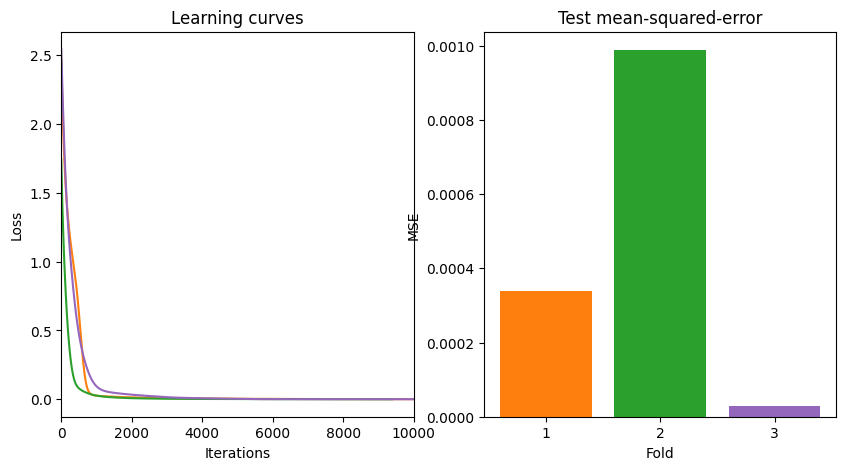

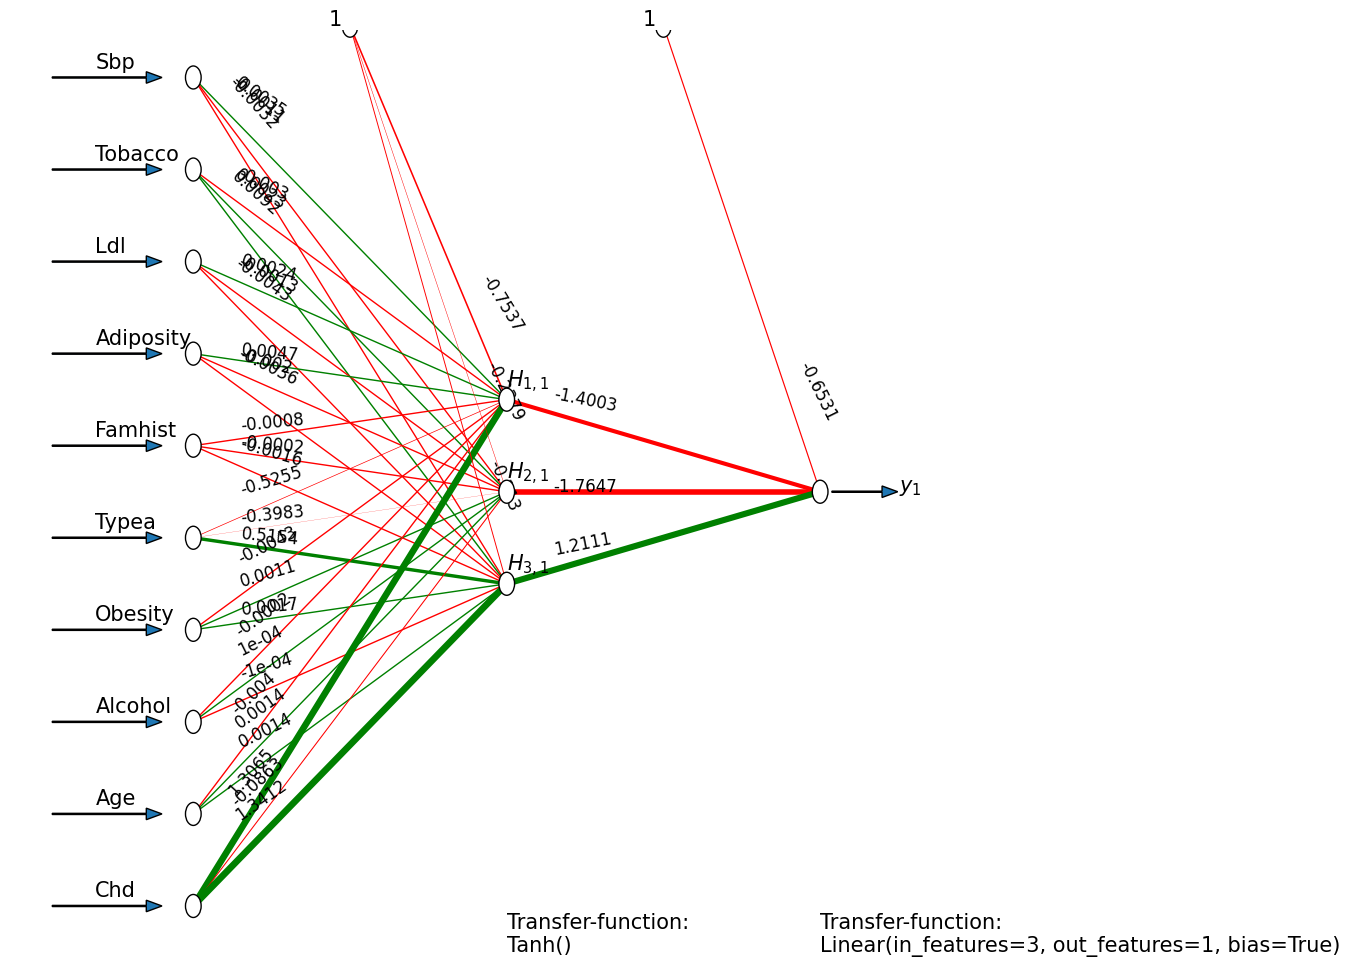


Estimated generalization error, RMSE: 0.021299999207258224


In [6]:
from sklearn.metrics import mean_squared_error
# exercise 8.2.2
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat
from sklearn import model_selection


from dtuimldmtools import (
    draw_neural_net,
    train_neural_net,
    visualize_decision_boundary,
    rlr_validate,
)

# exercise 5.1.1
import pandas as pd
import numpy as np
from scipy.stats import zscore

url = "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data"

# Load the SAheart dataset
df = pd.read_csv(url, index_col='row.names')


# Convert binary text data to numbered categories
df['famhist'] = pd.Categorical(df['famhist']).codes
y=np.asarray(np.asmatrix(df["chd"].values).T).squeeze()


# Attribute names
attributeNames = list(map(lambda x: x.capitalize(), df.columns.tolist()))

X = df.to_numpy()
y = df['typea'].to_numpy().reshape(-1, 1)
N, M = X.shape
classNames = [0, 1]
C = len(classNames)

X = zscore(X, ddof=1)  # Mean = 0, Std = 1
y = zscore(y, ddof=1)  # Mean = 0, Std = 1

# Step 2: Normalization (Min-Max Scaling to [0,1])
# X = (X_standardized - X_standardized.min()) / (X_standardized.max() - X_standardized.min())
# y = (y_standardized - y_standardized.min()) / (y_standardized.max() - y_standardized.min())



# Define the model structure
n_hidden_units = 3  # number of hidden units in the signle hidden layer
# The lambda-syntax defines an anonymous function, which is used here to
# make it easy to make new networks within each cross validation fold


# Since we're training a neural network for binary classification, we use a
# binary cross entropy loss (see the help(train_neural_net) for more on
# the loss_fn input to the function)

# Train for a maximum of 10000 steps, or until convergence (see help for the
# function train_neural_net() for more on the tolerance/convergence))
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000
print("Training model of type:\n{}\n".format(str(model())))
# K-fold crossvalidation
K = 3  # only three folds to speed up this example
CV = model_selection.KFold(K, shuffle=True)


# Do cross-validation:
errors = []  # make a list for storing generalizaition error in each loop
# Loop over each cross-validation split. The CV.split-method returns the
# indices to be used for training and testing in each split, and calling
# the enumerate-method with this simply returns this indices along with
# a counter k:

mse_scores = []

summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]

model_ANN = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop

lambda_count = 50

# Values of lambda
lambdas = np.logspace(-2, 6, lambda_count)

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model_ANN,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

     ## Baseline
    y_baseline = np.mean(y_train)

    # Predict the same mean value for all test samples
    y_pred_baseline = np.full_like(y_test, y_baseline)

    # Compute and store the MSE
    mse = mean_squared_error(y_test, y_pred_baseline)
    mse_scores.append(mse)


    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )



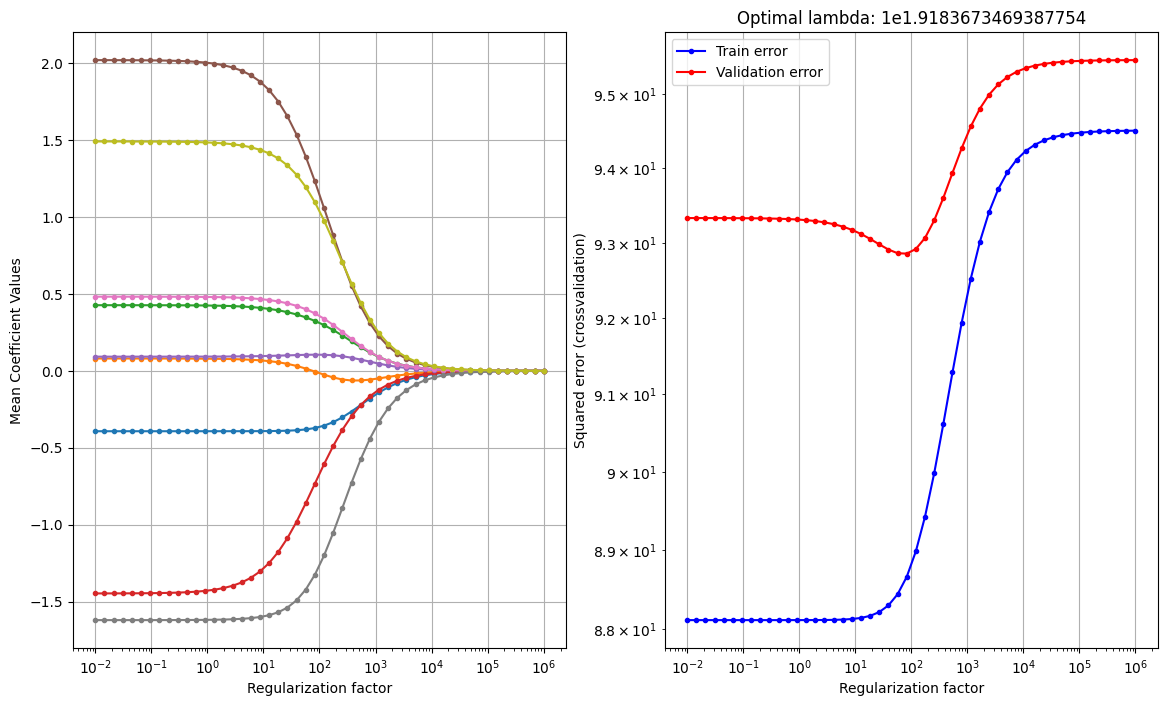

Linear regression without feature selection:
- Training error: 90.25357913678559
- Test error:     94.03020551544658
- R^2 train:     0.06142211359552297
- R^2 test:     0.009388555075044316

Regularized linear regression:
- Training error: 90.77802090995455
- Test error:     93.64883741009459
- R^2 train:     0.05596826394533755
- R^2 test:     0.013406281164444131

Weights in last fold:
         Offset           53.19
            Sbp           -0.37
        Tobacco             0.0
            Ldl            0.33
      Adiposity           -0.77
        Famhist             0.1
        Obesity            1.28
        Alcohol            0.38
            Age           -1.36
            Chd            1.13


In [8]:
import pandas as pd
import numpy as np

url = "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data"

# Load the SAheart dataset
df = pd.read_csv(url, index_col='row.names')

# Convert binary text data to numbered categories
df['famhist'] = pd.Categorical(df['famhist']).codes

# Extract the target attribute, and remove it from the training data
y = np.asarray(np.asmatrix(df["typea"].values).T).squeeze()
df = df.drop(columns=["typea"])

# Attribute names
attributeNames = list(map(lambda x: x.capitalize(), df.columns.tolist()))

# Convert the training data to a numpy array
X = df.to_numpy()
N, M = X.shape
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from dtuimldmtools import rlr_validate


# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

lambda_count = 50

# Values of lambda
lambdas = np.logspace(-2, 6, lambda_count)

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        plt.figure(k, figsize=(14, 8))
        plt.subplot(1, 2, 1)
        plt.semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        plt.xlabel("Regularization factor")
        plt.ylabel("Mean Coefficient Values")
        plt.grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        plt.subplot(1, 2, 2)
        plt.title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        plt.loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        plt.xlabel("Regularization factor")
        plt.ylabel("Squared error (crossvalidation)")
        plt.legend(["Train error", "Validation error"])
        plt.grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1
plt.savefig('regression_lambda.png')
plt.show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

In [7]:
# Two-layer cross validation

# K-fold for cross validation
Kfold = 10
CV = model_selection.KFold(Kfold)
error_OUT = []

k = 0
lambdas = 10
# Outer fold
for train_index_out, test_index_out in CV.split(X,y):
    print("# Outer fold: {0}/{1}".format(k + 1, Kfold))

    # Extract the training and test set for the outer-fold
    X_train_out = X[train_index_out, :]
    y_train_out = y[train_index_out]
    X_test_out = X[test_index_out, :]
    y_test_out = y[test_index_out]

    i = 0 # Index for inner fold
    error_IN = [] # Emptry list for inner fold errors

    # Inner fold
    for train_index, test_index in CV.split(X_train_out, y_train_out):
        print("Inner fold: {0}/{1}".format(i + 1, Kfold))

        # Extract training and test set for current inner fold
        X_train = X_train_out[train_index, :]
        y_train = y_train_out[train_index]
        X_test = X_train_out[test_index, :]
        y_test = y_train_out[test_index]


        # Training and test of the three models
        ## K-nearest neigbors
       model_ANN.fit(X_train, y_train)

        # test
        y_est_KNN = knclassifier.predict(X_test)
        Missclass_KNN = np.sum(y_est_KNN != y_test)



        ## Baseline
        y_baseline = np.mean(y_train)

        # Predict the same mean value for all test samples
        y_pred_baseline = np.full_like(y_test, y_baseline)

        # Compute and store the MSE
        mse = mean_squared_error(y_test, y_pred_baseline)
        mse_scores.append(mse)







Class_df_columns = pd.MultiIndex.from_tuples([
    ("Outer fold", "i"),
    ("KNN", "k"),
    ("KNN", "Error_test (%)"),
    ("Logistic regression", "lambda"),
    ("Logistic regression", "Error_test(%)"),
    ("Baseline", "Error_test(%)")])

Outer_fold = np.round(np.arange(1, Kfold + 1),0)

Class_df_data = np.array([Outer_fold,
                          np.full(Kfold, k_KNN), # k-value
                          np.round(np.array(error_OUT)[:,0],2), # Error_test of KNN
                          np.full(Kfold, 0), # Lambda
                          np.round(np.array(error_OUT)[:,1],2), # Error_test of logistic function
                          np.round(np.array(error_OUT)[:,2],2)]).T

Class_df = pd.DataFrame(Class_df_data, columns=Class_df_columns)
print(Class_df)


/Users/dhanna/Documents/Egyetem/DTU/1_Semester/IntroductionToMachineLearning/Report/Report_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dhanna/Documents/Egyetem/DTU/1_Semester/IntroductionToMachineLearning/Report/Report_1/.venv/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/dhanna/Documents/Egyetem/DTU/1_Semester/IntroductionToMachineLearning/Report/Report_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

Linear Regression - Cross-Validation MSE: 0.0000
SVR - Cross-Validation MSE: 0.0680
Random Forest - Cross-Validation MSE: 0.0051


/Users/dhanna/Documents/Egyetem/DTU/1_Semester/IntroductionToMachineLearning/Report/Report_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dhanna/Documents/Egyetem/DTU/1_Semester/IntroductionToMachineLearning/Report/Report_1/.venv/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/dhanna/Documents/Egyetem/DTU/1_Semester/IntroductionToMachineLearning/Report/Report_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e